## Ingeniería y Selección de Variables

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Motivación

> "All models are wrong, but some are useful" – George E. P. Box

La Ingeniería y Selección de Variables se refiere al proceso de encontrar un subconjunto relevante de variables exógenas (independientes) para el uso en construcción de Modelos Estadísticos y/o de Machine Learning. En otras palabras, se trata de encontrar las variables más importantes para el modelo con respecto a la métrica que deseamos optimizar.


### Objetivos

- Remover variables con baja varianza.
- Remover variables altamente correlacionadas.
- Remover variables que no son predictivas.

#### Ejemplo 1

In [2]:
x1 = np.arange(10)
x2 = 0.5 * np.arange(9, 4, -0.5)
x3 = np.array([4.7, 9.8, 6.5, 6.7, 1.4, 0.0, 5.7, 0.3, 9.1, 5.1])
y = np.array([2.68, 2.66, 2.92, 2.86, 2.9, 2.92, 3.07, 3.03, 2.94, 3.02])


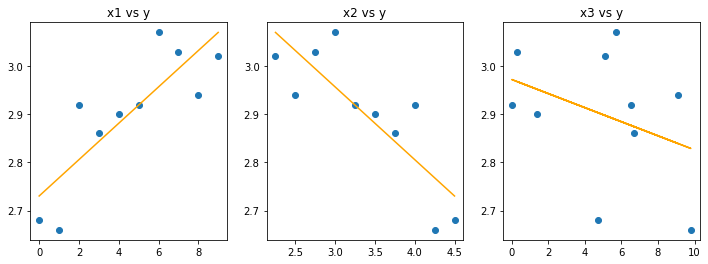

In [3]:
ols = LinearRegression()

ols.fit(x1[:, np.newaxis], y)
y1 = ols.predict(x1[:, np.newaxis])
ols.fit(x2[:, np.newaxis], y)
y2 = ols.predict(x2[:, np.newaxis])
ols.fit(x3[:, np.newaxis], y)
y3 = ols.predict(x3[:, np.newaxis])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(x1, y)
ax1.plot(x1, y1, "orange")
ax1.set_title("x1 vs y")
ax2.scatter(x2, y)
ax2.plot(x2, y2, "orange")
ax2.set_title("x2 vs y")
ax3.scatter(x3, y)
ax3.plot(x3, y3, "orange")
ax3.set_title("x3 vs y")
plt.show()

### Colinearidad / Multicolinearidad

Ocurre cuando una o más variables exógenas están altamente correlacionadas. Esto puede ocurrir por varias razones: una o más variables dependen linealmente de otra, o un subconjunto de variables dependen de una variable latente, que no es explícita. 

##### Problemas que produce la Multicolinearidad
- Los coeficientes del modelo no están únicamente determinados.
- Coeficienties altamente sensibles a pequeños cambios en las variables. 
- Reduce la significancia estadística de los resultados.
- Conduce a interpretaciones ambiguas.
- Añade ineficiencia en modelos con alta dimensionalidad.  

#### Ejemplo 2.

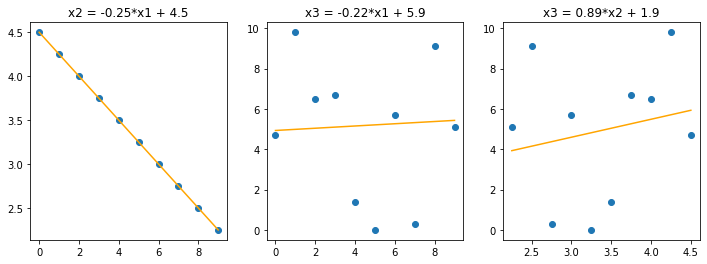

In [4]:
ols.fit(x1[:, np.newaxis], x2)
x_12 = ols.predict(x1[:, np.newaxis])
(a_12,), b_12 = ols.coef_, ols.intercept_
ols.fit(x1[:, np.newaxis], x3)
x_13 = ols.predict(x2[:, np.newaxis])
a_13, b_13 = ols.coef_, ols.intercept_
ols.fit(x2[:, np.newaxis], x3)
x_23 = ols.predict(x2[:, np.newaxis])
a_23, b_23 = ols.coef_, ols.intercept_

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(x1, x2)
ax1.plot(x1, x_12, "orange")
ax1.set_title("x2 = %.2f*x1 + %.1f" % (a_12, b_12))
ax2.scatter(x1, x3)
ax2.plot(x1, x_13, "orange")
ax2.set_title("x3 = %.2f*x1 + %.1f" % (a_13, b_13))
ax3.scatter(x2, x3)
ax3.plot(x2, x_23, "orange")
ax3.set_title("x3 = %.2f*x2 + %.1f" % (a_23, b_23))
plt.show()

### Matriz de Covarianza

#### Ejemplo 3.

In [5]:
# Límite de correlación
threshold = 0.9
# Matriz de Variables
X = np.vstack([x1, x2, x3]).T
# Matriz de Correlación
K = np.abs(np.corrcoef(X, rowvar=False))
print("Matriz de Correlación")
print(K)

# Selecccionar matriz triangular, excluír diagonal
U = np.triu(K, k=1)
# Encontrar pares de variables con correlación mayor a `threshold`
collinear = np.argwhere(U > threshold)
print("Variables colineales: %s" % collinear)
# Conservar la variable explanatoria con mayor varianza
for pair in collinear:
    s = np.var(X[:, pair], axis=0)
    print("Varianza del par %s: %s" % (pair, s))
    print("Conservar variable %s" % np.argmax(s))

Matriz de Correlación
[[1.        1.        0.1966148]
 [1.        1.        0.1966148]
 [0.1966148 0.1966148 1.       ]]
Variables colineales: [[0 1]]
Varianza del par [0 1]: [8.25     0.515625]
Conservar variable 0


### Coeficiente de Determinación

Conocido como $R^2$, comunmente mal interpretado. Por si solo, este coeficiente cuantifica la proporción de variación de los resultados que pueden ser explicados por el modelo. Sin embargo, es útil para Selección de Variables al usarlo en conjunto con otras técnicas, como VIF y Regresión Paso-a-Paso.

### Factor de Inflación de la Varianza (VIF)

Cuantifica hasta que punto la varianza de un coeficiente de regresión se incrementa a causa de la colinearidad. En otras palabras, durante la selección de variables queremos conservar la variable explanatoria que cause menos varianza en los coeficientes de regresión.  

El VIF de la variable $x_i$ se calcula usando el Coeficiente de Determinación $R^2_{i}$ con respecto al modelo lineal  

$$
x_i = a_0 + \Sigma_{j=1, j\neq i}^{k} a_jx_j + \epsilon
$$


In [6]:
for pair in collinear:   
    vif = [
        variance_inflation_factor(X[:, pair], idx) for idx in range(len(pair))
    ]
    print("VIF del par %s: %s" % (pair, vif))
    print("Conservar variable %s" % np.argmin(vif))


VIF del par [0 1]: [2.0311447811447807, 2.031144781144781]
Conservar variable 0


### Regresión Paso-a-Paso

Este tipo de regresión nos permite seleccionar un subconjunto de variables de un grupo relativamente grande. Existen dos tipos de Regresión Paso-a-Paso: hacia adelante y hacia atrás. 

#### Hacia adelante
Iniciar con 0 variables candidatas en el modelo. Seleccionar la variable que tiene el coeficiente $R^2$ más alto. Luego en cada paso, seleccionar la variable que incremente el coeficiente $R^2$ en mayor cantidad. Parar cuando ninguna de las variables restantes incrementen el coeficiente $R^2$.

#### Hacia atrás.
Iniciar con todas las variables candidatas en el modelo. En cada paso, la variable menos significante es removida hasta que no quede ninguna variable no significante.

#### Ejemplo 4.

In [7]:
n = 10
p = 3
threshold = 0.5
to_keep = np.arange(p)

ols.fit(X, y)
y_hat = ols.predict(X)
r2_0 = r2_score(y, y_hat)
print("R^2 con todas las variables: %.2f" % r2_0)

if r2_0 < threshold:
    raise RuntimeError("No variables were selected")

for i in range(p, 1, -1):
    X_p = X[:, :i]
    ols.fit(X_p, y)
    y_hat = ols.predict(X_p)
    r2 = r2_score(y, y_hat)
    if r2 < r2_0:
        print("Nuevo R^2: %.2f. Remover variable %s" % (r2, p - i))
    else:
        r2_0 = r2


R^2 con todas las variables: 0.73
Nuevo R^2: 0.69. Remover variable 1
